Copyright (c) 2015, 2016 [Sebastian Raschka](sebastianraschka.com)
<br>
2016 [Li-Yi Wei](http://www.liyiwei.org/)

https://github.com/1iyiwei/pyml

[MIT License](https://github.com/1iyiwei/pyml/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 12 - Training Artificial Neural Networks for Image Recognition

Deep learning
* hot topic
* neural networks with many layers (i.e. in the range of hundreds or thousands) 

Basic understanding of multi-layer neural networks
* predict via forward propagation
* training via backp ropagation
* application in handwritten digit classification
* debugging

Other types of neural networks
* CNN - convolutional neural networks
* RNN - recurrent neural networks

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,scipy,matplotlib

last updated: 2016-11-07 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
scipy 0.17.1
matplotlib 1.5.1


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

### Overview

- [Modeling complex functions with artificial neural networks](#Modeling-complex-functions-with-artificial-neural-networks)
  - [Single-layer neural network recap](#Single-layer-neural-network-recap)
  - [Introducing the multi-layer neural network architecture](#Introducing-the-multi-layer-neural-network-architecture)
  - [Activating a neural network via forward propagation](#Activating-a-neural-network-via-forward-propagation)
- [Classifying handwritten digits](#Classifying-handwritten-digits)
  - [Obtaining the MNIST dataset](#Obtaining-the-MNIST-dataset)
  - [Implementing a multi-layer perceptron](#Implementing-a-multi-layer-perceptron)
- [Training an artificial neural network](#Training-an-artificial-neural-network)
  - [Computing the logistic cost function](#Computing-the-logistic-cost-function)
  - [Training neural networks via backpropagation](#Training-neural-networks-via-backpropagation)
- [Developing your intuition for backpropagation](#Developing-your-intuition-for-backpropagation)
- [Debugging neural networks with gradient checking](#Debugging-neural-networks-with-gradient-checking)
- [Convergence in neural networks](#Convergence-in-neural-networks)
- [Other neural network architectures](#Other-neural-network-architectures)
  - [Convolutional Neural Networks](#Convolutional-Neural-Networks)
  - [Recurrent Neural Networks](#Recurrent-Neural-Networks)
- [A few last words about neural network implementation](#A-few-last-words-about-neural-network-implementation)
- [Summary](#Summary)

In [2]:
from IPython.display import Image
%matplotlib inline

# Modeling complex functions with artificial neural networks

We introduced single-layer neural networks for linear classification.

Mutli-layer neural network is an extension of single-layer neural networks.

A bit history of multi-layer neural networks:
* Started in the 1950s, but has been limited by available data and computation power.
* Regained popularity in recent years due to data explosion and Moore's law.

Simple algorithms can work well with enough data and computation
* [bid your time](http://www.macleans.ca/society/science/the-meaning-of-alphago-the-ai-program-that-beat-a-go-champ/)

Many cool applications:
* largely pursued by companies such as Google, Facebook, Amazon, Microsoft, Apple, Baidu, etc.

## Single-layer neural network recap

<img src='./images/12_01.png' width=80%> 

$\mathbf{x}$: input sample,
$y$: corresponding label

$\mathbf{w}$: weight parameters

$\mathbf{z}$: linear input
$$
z = \mathbf{w}^T \mathbf{x}
$$

$a$: activation,
$\phi$: activation function:
$$
a = \phi(z)
$$

* Direct thresholding - perceptron

* Linear activation function - Adaline
$$
\phi(z) = z
$$

* Sigmoid activation function - logistic regression
$$
\phi(z) = \frac{1}{1+e^{-z}}
$$

$\hat{y}$: predicted output
$$
\begin{align}
\hat{y} &= 
\begin{cases}
1 & \phi(z) \geq 0
\\ 
-1 & \phi(z) < 0
\end{cases}
\end{align}
$$

### Training single-layer network

#### Objective function

Sum-of-squared error for linear activation:
$$
\begin{align}
J\left(\mathbf{w}\right) = \frac{1}{2} \sum_i \left( \phi\left(z^{(i)}\right) - y^{(i)} \right)^2
\end{align}
$$

Logistic regression for Sigmoid:
$$
\begin{align}
J\left(\mathbf{w} \right) = \sum_i -y^{(i)}\log\left(\phi\left(z^{(i)}\right)\right) - \left(1 - y^{(i)} \right) \log\left(1 - \phi\left( z^{(i)}\right) \right)
\end{align}
$$

#### Derivative

With proper (clever?) combination of $J$ and $\phi$ we can reach a simple and elegant derivative:
$$
\begin{align}
\frac{\partial J}{\partial \mathbf{w}} &=
\sum_i \mathbf{x}^{(i)} \left( \phi\left(z^{(i)}\right) - y^{(i)} \right)
\end{align}
$$
The above formula works for perceptron, adaptive linear neuron, and logistic regression.

#### Gradient descent:
$$
\begin{align}
\delta \mathbf{w} &= -\eta \frac{\partial J}{\partial \mathbf{w}}
\\
\mathbf{w} &\leftarrow \mathbf{w} + \delta \mathbf{w}
\end{align}
$$

Stochastic gradient descent
* Just take a subset instead of all samples in computing $\frac{\partial J}{\partial \mathbf{w}}$

## Vector version

We can assume all functions and operators take on vector inputs similar to scalar inputs, just operate component-wise.
For example:
$$
\begin{align}
\mathbf{v} &= \left(v_1, v_2, \cdots, v_n \right)
\\
f(\mathbf{v}) &=  \left(f\left(v_1\right), f\left(v_2\right), \cdots, f\left(v_n\right) \right)
\end{align}
$$
And
$$
\begin{align}
\mathbf{x} &= \left(x_1, x_2, \cdots, x_n \right)
\\
\mathbf{y} &= \left(y_1, y_2, \cdots, y_n \right)
\\
\mathbf{x} + \mathbf{y} &= \left(x_1 + y_1, x_2 + y_2, \cdots, x_n + y_n \right)
\\
\mathbf{x} * \mathbf{y} &= \left(x_1 * y_1, x_2 * y_2, \cdots, x_n * y_n \right)
\end{align}
$$

We can also keep the inner product:
$$
\begin{align}
\mathbf{x} \mathbf{y} &= \sum_{i=1}^n x_i y_i
\end{align}
$$

Then we can directly use any output cost function, such as in logistic regression:
$$
\begin{align}
L\left(\mathbf{W}, \mathbf{X}, \mathbf{Y} \right) &= \sum_i -\mathbf{y}^{(i)}\log\left(\mathbf{a}^{(i)}\right) - \left(1 - \mathbf{y}^{(i)} \right) \log\left(1 - \mathbf{a}^{(i)} \right)
\end{align}
$$
* $i$ runs through all training samples
* $\mathbf{y}$ one-hot vector for classification
$$
\begin{align}
\mathbf{a^{(i)}} =
\begin{bmatrix}
0.1
\\
0.9
\\
\vdots
\\
0.3
\end{bmatrix}
,
\mathbf{y^{(i)}} =
\begin{bmatrix}
0
\\
1
\\
\vdots
\\
0
\end{bmatrix}
\end{align}
$$
* $\mathbf{W}$ is the set of all weights in the network (across all layers) 

## Introducing the multi-layer neural network architecture

We can extend single layer networks to multiple layers

Often called:
* multi-layer feedforward neural network
* multi-layer perceptron (MLP) even if other types of activations are used

### MLP example

One hidden layer

Two weight layers
* input layer fully connected to hidden layer
* hidden layer fully connected to output layer

Connection types
* full: every node in one layer is connected to every node in another layer
* other types possible, such as convolutional (to describe later)

<img src='./images/12_02.png' width=60%> 

Hyper-parameters
* network architecture
* number of layers
* number of nodes in each layer
* bias: $x_0 = a_0 = 1$

### Why multiple layers?

The latter layers collect information from earlier layers, and can process higher level information.

Different layers focus on different levels of information.

Facial recognition example:
* earlier layers: identify eyes, nose, mouth, etc.
* later layers: identify the relative positions of eyes, noise, mouth, etc.

<a href="http://www.salon.com/2013/04/22/why_facial_recognition_failed/">
<img src="http://media.salon.com/2013/04/facial_recognition-620x412.jpg">
</a>

### MLP representation

$\mathbf{a}_j^{(i)}$: $j$th node in the $i$th activation layer

$\mathbf{a}^{(1)} = \mathbf{x}$: the input can be considered as the first activation

$\mathbf{W}_{j,k}^{(\ell)}$: weight connecting $k$th node in layer $\ell$ to $j$th node in layer $\ell+1$
* like for matrix multiplication: $\mathbf{z}^{\ell+1} = \mathbf{W}^{(\ell)} \mathbf{a}^{(\ell)}$

Can have multiple outputs for multi-class classification
* e.g. one hot: (1, 0, 0) for class 1, (0, 1, 0) for class 2, (0, 0, 1) for class 3

<img src='./images/12_03.png' width=80%> 

### Number of layers

People use different conventions to count the number of layers for a network.

<a href="http://neuralnetworksanddeeplearning.com/">
<img src="http://neuralnetworksanddeeplearning.com/images/tikz11.png">
</a>

Number of layers with weights 
* e.g. adding a threshold after activation does not count as another layer
* avoid ambiguity
* reflect computational power and complexity

Number of hidden layers (with weights) for multi-layer networks

Number of input + output + hidden layers
* usually 1 + number of weight layers

Deep neural network
* conventional definition: $>1$ hidden layer
* modern definition: a lot more than that (hundreds or thousands)

# MLP classifying and training

Both are extensions from the single layer networks.

Called forward and backward propagation for MLP.

## Overview

1.
Starting at the input layer, we forward propagate the activations from one layer to the next until we reach the last layer to produce the output.

<img src='./images/12_11.png' width=50%>

2.
Based on the output, we calculate the error that we want to minimize with a cost function.

3.
We backpropagate the error, find its derivative with respect to each weight in the network, and update the model weights.

<img src='./images/12_12.png' width=60%> 

Classification/forward-propagation takes step 1.

Training/back-propagation repeats steps 1 to 3 (through multiple batches/epochs).


## Activating a neural network via forward propagation

Pass the input sample $\mathbf{x}$ through each layer of the network.

Start from the input layer (initialization):
$$
\begin{align}
\mathbf{a}^{1} = \mathbf{x}
\end{align}
$$

For each layer $\ell \in [1, 2, \cdots, L-1]$ where the last layer is $L$:
$$
\begin{align}
\mathbf{z}^{(\ell + 1)} &= \mathbf{W}^{(\ell)} \mathbf{a}^{(\ell)} 
\\
\mathbf{a}^{(\ell + 1)} &= \phi\left( \mathbf{z}^{(\ell+1)}\right)
\end{align}
$$

Compute the output via certain output function $o$ (thresholding, one-hot, softmax, etc.):
$$
\hat{\mathbf{y}} = o\left(\mathbf{a}^{(L)}\right)
$$

<img src='./images/12_03.png' width=50%> 


Start from the input layer (initialization):
$$
\begin{align}
\mathbf{a}^{1} = \mathbf{x}
\end{align}
$$

For each layer $\ell \in [1, 2, \cdots, L-1]$ where the last layer is $L=3$:

$$
\begin{align}
\mathbf{W}^{(1)} &: 3 \times 4 \; \mbox{matrix}
\\
\mathbf{z}^{(2)} &= \mathbf{W}^{(1)} \mathbf{a}^{(1)} 
\\
\mathbf{a}^{(2)} &= \phi\left( \mathbf{z}^{(2)}\right)
\end{align}
$$

$$
\begin{align}
\mathbf{W}^{(2)} &: 3 \times 4 \; \mbox{matrix}
\\
\mathbf{z}^{(3)} &= \mathbf{W}^{(2)} \mathbf{a}^{(2)} 
\\
\mathbf{a}^{(3)} &= \phi\left( \mathbf{z}^{(3)}\right)
\end{align}
$$

Compute the output via certain output function $o$ (thresholding, one-hot, softmax, etc.):
$$
\hat{\mathbf{y}} = o\left(\mathbf{a}^{(3)}\right)
$$

## Generalization to multiple inputs

We can generalize the above to handle multiple inputs $\mathbf{X}$ instead of just one input sample $\mathbf{x} \in \mathbf{X}$.
* Recall the rows/cols of matrix $\mathbf{X}$ correspond to the samples/features.

Matrix multiplication and vector/matrix function evaluation allow us to simply capitalize all lower case symbols into upper case ones.

<img src='./images/12_11.png' width=50% align=right>

Start from the input layer (initialization):
$$
\begin{align}
\mathbf{A}^{1} = \mathbf{X}^T
\end{align}
$$
* the transpose is to convert samples from rows into columns for subsequent matrix multiplication

For each layer $\ell \in [1, 2, \cdots, L-1]$ where the last layer is $L$:
$$
\begin{align}
\mathbf{Z}^{(\ell + 1)} &= \mathbf{W}^{(\ell)} \mathbf{A}^{(\ell)}
\\
\mathbf{A}^{(\ell + 1)} &= \phi\left( \mathbf{Z}^{(\ell+1)}\right)
\end{align}
$$

Compute the output via certain output function $o$ (thresholding, one-hot, softmax, etc.):
$$
\hat{\mathbf{Y}} = o\left(\mathbf{A}^{(L)}\right)
$$


## Activation function

Choose non-linear functions for internal activations to solve general problems.

If all internal nodes have linear activation, we can show that a multi-layer network can be reduce to a single layer network.

Sigmoid $\phi(z) = \frac{1}{1 + e^{-z}}$ and tanh $\phi(z) = \frac{1-e^{-z}}{1+e^{-z}}$ are common choices for activation $\phi$ in hidden layers.

ReLu is chosen for deep networks for faster convergence.
$$
\phi(z) = \max\left(0, z\right)
$$

<!--
<img src='./images/12_04.png' width=80%> 
-->

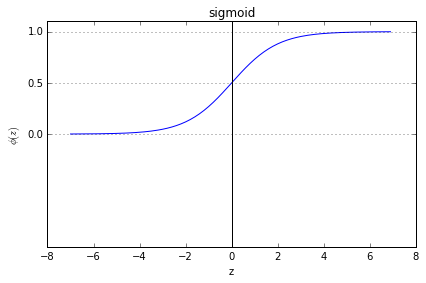

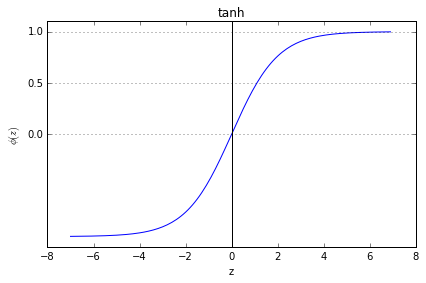

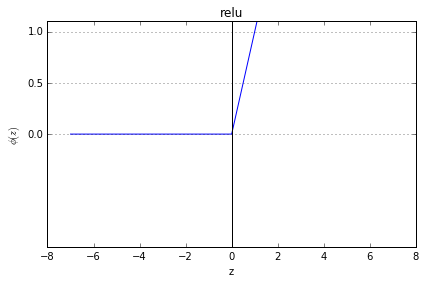

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_func(x, y, title):
    plt.plot(x, y)
    plt.axvline(0.0, color='k')
    plt.ylim(-1.1, 1.1)
    plt.xlabel('z')
    plt.ylabel('$\phi (z)$')

    # y axis ticks and gridline
    plt.yticks([0.0, 0.5, 1.0])
    ax = plt.gca()
    ax.yaxis.grid(True)

    plt.title(title)
    plt.tight_layout()
    plt.show()

def linear(z):
    return z

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def tanh(z):
    return (1.0 - np.exp(-z))/(1.0 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

z = np.arange(-7, 7, 0.1)

activations = ['sigmoid', 'tanh', 'relu']

for i, activation in enumerate(activations):
    if(activation == 'sigmoid'):
        phi_z = sigmoid(z)
    elif (activation == 'tanh'):
        phi_z = tanh(z)
    elif (activation == 'relu'):
        phi_z = relu(z)
    else:
        phi_z = linear(z)
        
    plot_func(z, phi_z, activation)

# Classifying handwritten digits

Let's apply MLP for a practical application before talking more about math and algorithms.

## The MNIST dataset

A popular dataset for testing machine learning algorithms.

Mixed National Institute of Standards and Technology database, constructed by Yann LeCun.
* the origin of ATM taking checks

Handwritten digits from 250 people
* 50% high school students
* 50% Census Bureau employees

Properties
* $\mathbf{X}$: $28 \times 28$-pixel images
* $\mathbf{y}$: labels in $[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]$
* 60,000 training samples
* 10,000 test samples

## Obtaining the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 samples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 samples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)

In this section, we will only be working with a subset of MNIST, thus, we only need to download the training set images and training set labels. After downloading the files, I recommend unzipping the files using the Unix/Linux gzip tool from the terminal for efficiency, e.g., using the command 

    gzip *ubyte.gz -d
 
in your local MNIST download directory, or, using your favorite unzipping tool if you are working with a machine running on Microsoft Windows. The images are stored in byte form, and using the following function, we will read them into NumPy arrays that we will use to train our MLP.


Li-Yi: I enhanced the functions below so that we can do everything (including downloading and decompression) inside ipynb. 

In [4]:
import os
import os.path
import struct
import gzip
import numpy as np
 
def open_mnist(full_path):
    if full_path.find('.gz') >= 0:
        return gzip.open(full_path, 'rb')
    else:
        return open(full_path, 'rb')
        
def pick_mnist(path, name, exts):
    for ext in exts:
        full_path = os.path.join(path, name + ext)
        if os.path.isfile(full_path):
            return full_path
    # none of the exts options works    
    return None

def load_mnist(path, kind='train', exts=['', '.gz']):
    """Load MNIST data from `path`"""
    labels_path = pick_mnist(path, kind + '-labels-idx1-ubyte', exts)
    images_path = pick_mnist(path, kind + '-images-idx3-ubyte', exts)
    
    with open_mnist(labels_path) as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))        
        if(magic != 2049):
            raise IOError(str(magic) + ' != ' + str(2049))
            
        # np.fromfile does not work with gzip open   
        # http://stackoverflow.com/questions/15966335/efficient-numpy-fromfile-on-zipped-files
        # labels = np.fromfile(lbpath, dtype=np.uint8)
        content = lbpath.read()    
        labels = np.frombuffer(content, dtype=np.uint8)
        if(len(labels) != n):
            raise IOError(str(len(labels)) + ' != ' + str(n))
        
    with open_mnist(images_path) as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        if(magic != 2051):
            raise IOError(str(magic) + ' != ' + str(2051))
            
        # images = np.fromfile(imgpath, dtype=np.uint8).reshape(num, rows*cols)
        content = imgpath.read()    
        images = np.frombuffer(content, dtype=np.uint8).reshape(num, rows*cols)
        if(num != len(labels)):
            raise IOError(str(num) + ' != ' + str(len(labels)))
            
    return images, labels

In [5]:
mnist_data_folder = os.path.join('..', 'datasets', 'mnist')
exts = ['', '.gz'] # for already gunzipped files and not yet gzipped files

X_train, y_train = load_mnist(mnist_data_folder, kind='train', exts=exts)
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
X_test, y_test = load_mnist(mnist_data_folder, kind='t10k', exts=exts)
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


Note we flatten each $28\times28$ image into a $784 = 28^2$ vector as input to the neural network.

Visualize the first digit of each class:

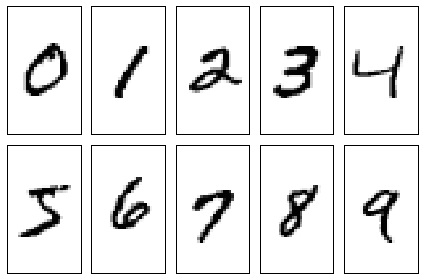

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_all.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

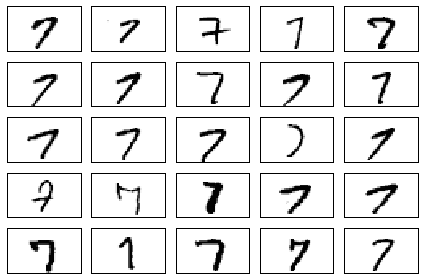

In [7]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_7.png', dpi=300)
plt.show()

Uncomment the following lines to optionally save the data in CSV format. 
However, note that those CSV files will take up a substantial amount of storage space:

- train_img.csv 1.1 GB (gigabytes)
- train_labels.csv 1.4 MB (megabytes)
- test_img.csv 187.0 MB
- test_labels 144 KB (kilobytes)


In [8]:
# np.savetxt('train_img.csv', X_train, fmt='%i', delimiter=',')
# np.savetxt('train_labels.csv', y_train, fmt='%i', delimiter=',')
# X_train = np.genfromtxt('train_img.csv', dtype=int, delimiter=',')
# y_train = np.genfromtxt('train_labels.csv', dtype=int, delimiter=',')

# np.savetxt('test_img.csv', X_test, fmt='%i', delimiter=',')
# np.savetxt('test_labels.csv', y_test, fmt='%i', delimiter=',')
# X_test = np.genfromtxt('test_img.csv', dtype=int, delimiter=',')
# y_test = np.genfromtxt('test_labels.csv', dtype=int, delimiter=',')


## Implementing a multi-layer perceptron

This is an implementation of a single-hidden neural network.

scikit-learn does not contain neural network stuff, but there are other options that we can use.
* e.g. Keras, Torch7, Theano, Caffe, TensorFlow, etc.

We have not talked about backpropagation yet, but having this code as reference can help understanding.

In [9]:
import numpy as np
from scipy.special import expit
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the
        number of unique class labels.
    n_features : int
        Number of features (dimensions) in the target dataset.
        Should be equal to the number of columns in the X array.
    n_hidden : int (default: 30)
        Number of hidden units.
    l1 : float (default: 0.0)
        Lambda value for L1-regularization.
        No regularization if l1=0.0 (default)
    l2 : float (default: 0.0)
        Lambda value for L2-regularization.
        No regularization if l2=0.0 (default)
    epochs : int (default: 500)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    alpha : float (default: 0.0)
        Momentum constant. Factor multiplied with the
        gradient of the previous epoch t-1 to improve
        learning speed
        w(t) := w(t) - (grad(t) + alpha*grad(t-1))
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate
        after each epoch via eta / (1 + epoch*decrease_const)
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency.
        Normal gradient descent learning if k=1 (default).
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_labels, n_samples)

        """
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        w1 = np.random.uniform(-1.0, 1.0,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        # return 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new

    def _feedforward(self, X, w1, w2):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ----------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        z3 : array, shape = [n_output_units, n_samples]
            Net input of output layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.

        """
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) +
                                np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        # Li-Yi: there shouldn't be that 2.0 term for L1
        scale = 2.0 # original code
        scale = 1.0 # correct code (I think)
        return (lambda_/scale) * (np.abs(w1[:, 1:]).sum() +
                                  np.abs(w2[:, 1:]).sum())
        
    def _get_cost(self, y_enc, output, w1, w2):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        output : array, shape = [n_output_units, n_samples]
            Activation of the output layer (feedforward)
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float
            Regularized cost.

        """
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        grad1 : array, shape = [n_hidden_units, n_features]
            Gradient of the weight matrix w1.
        grad2 : array, shape = [n_output_units, n_hidden_units]
            Gradient of the weight matrix w2.
        both include the bias terms to match w1 and w2
        """
        # backpropagation
        sigma3 = a3 - y_enc # [num_output_units, num_samples]
        z2 = self._add_bias_unit(z2, how='row')
        # Li-Yi: we don't really need z2 as sigmoid_gradient(z2) = a2*(1-a2)
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2) # [n_hidden_units, num_samples]
        sigma2 = sigma2[1:, :] # remove the bias term
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        # Li-Yi: the L1 part doesn't seem correct to me
        # original code
        # grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        # grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))
        # corrected code
        # grad1[:, 1:] += (np.sign(w1[:, 1:]) * self.l1 + w1[:, 1:] * self.l2)
        # grad2[:, 1:] += (np.sign(w2[:, 1:]) * self.l1 + w2[:, 1:] * self.l2)
            
        grad1[:, 1:] += self.l2 * w1[:, 1:]
        grad1[:, 1:] += self.l1 * np.sign(w1[:, 1:])
        grad2[:, 1:] += self.l2 * w2[:, 1:]
        grad2[:, 1:] += self.l1 * np.sign(w2[:, 1:])

        return grad1, grad2

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(a3, axis=0) #Li-Yi: original code says z3 which doesn't seem right 
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        y : array, shape = [n_samples]
            Target class labels.
        print_progress : bool (default: False)
            Prints progress as the number of epochs
            to stderr.

        Returns:
        ----------
        self

        """
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

## Experiment of MLP with MNIST dataset

<img src="http://neuralnetworksanddeeplearning.com/images/tikz12.png">

In [10]:
num_epochs = 1000
num_batches = 50

nn = NeuralNetMLP(n_output=10, 
                  n_features=X_train.shape[1], 
                  n_hidden=50, 
                  l2=0.1, 
                  l1=0.0, 
                  epochs=num_epochs, 
                  eta=0.001,
                  alpha=0.001,
                  decrease_const=0.00001,
                  minibatches=num_batches, 
                  shuffle=True,
                  random_state=1)

In [11]:
_ = nn.fit(X_train, y_train, print_progress=True)

Epoch: 1000/1000

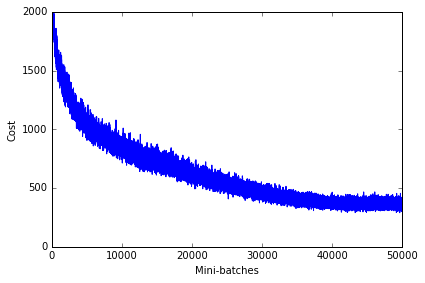

In [12]:
import matplotlib.pyplot as plt

# plot the cost for each mini-batch
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([0, 2000])
plt.ylabel('Cost')
# plt.xlabel('Epochs * ' + str(num_batches))
plt.xlabel('Mini-batches')
plt.tight_layout()
# plt.savefig('./figures/cost.png', dpi=300)
plt.show()

The cost curve is noisy due to the use of stochastic gradient descent.

We can smooth it out by averaging the cost for each epoch.

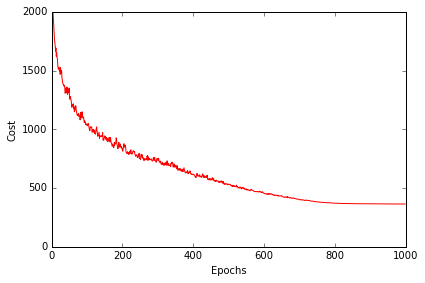

In [13]:
# plot the average cost per epoch
batches = np.array_split(range(len(nn.cost_)), num_epochs)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
#plt.savefig('./figures/cost2.png', dpi=300)
plt.show()

The process converged around 800 epochs.

In [14]:
y_train_pred = nn.predict(X_train)

if sys.version_info < (3, 0):
    acc = ((np.sum(y_train == y_train_pred, axis=0)).astype('float') /
           X_train.shape[0])
else:
    acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]

print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 97.67%


In [15]:
y_test_pred = nn.predict(X_test)

if sys.version_info < (3, 0):
    acc = ((np.sum(y_test == y_test_pred, axis=0)).astype('float') /
           X_test.shape[0])
else:
    acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 96.01%


Good accuracy (low bias)
* both the training and test accuracy are pretty good

Slight overfitting (low variance)
* test accuracy is slightly worse than training accuracy

We can tune the hyper-parameters via cross-validation and grid search, etc.
* exercise

Visualize the mis-classified digits:

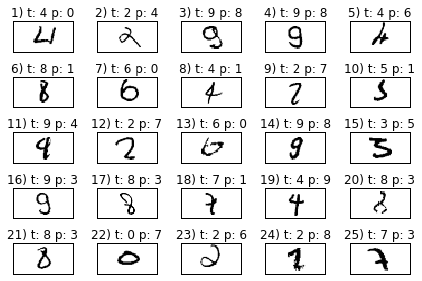

In [22]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_miscl.png', dpi=300)
plt.show()

In [24]:
import numpy as np  
import time  
import theano  
A = np.random.rand(1000,10000).astype(theano.config.floatX)  
B = np.random.rand(10000,1000).astype(theano.config.floatX)  
np_start = time.time()  
AB = A.dot(B)  
np_end = time.time()  
X,Y = theano.tensor.matrices('XY')  
mf = theano.function([X,Y],X.dot(Y))  
t_start = time.time()  
tAB = mf(A,B)  
t_end = time.time()  
print ("NP time: %f[s], theano time: %f[s] (times should be close when run on CPU!)" %(  
                                           np_end-np_start, t_end-t_start))  
print ("Result difference: %f" % (np.abs(AB-tAB).max(), ))

WARNING (theano.configdefaults): Only clang++ is supported. With g++, we end up with strange g++/OSX bugs.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


NP time: 0.355548[s], theano time: 0.428607[s] (times should be close when run on CPU!)
Result difference: 0.000000


Some of these are even difficult for humans to classify correctly.

# Training an artificial neural network

Now we see a neural network implementation and experimentation, we can talk about the training part.

## Computing the logistic cost function

Similar to the single-layer case, we can apply logistic cost function to the output layer:

$$
\begin{align}
\mathbf{a} &= \phi\left(\mathbf{z}\right)
\end{align}
$$


Specifically, the cost function will be:
$$
\begin{align}
L\left(\mathbf{W}, \mathbf{X}, \mathbf{Y} \right) &= \sum_i -\mathbf{y}^{(i)}\log\left(\mathbf{a}^{(i)}\right) - \left(1 - \mathbf{y}^{(i)} \right) \log\left(1 - \mathbf{a}^{(i)} \right)
\end{align}
$$
* $i$ runs through all training samples
* $\mathbf{y}$ one-hot vector for classification
$$
\begin{align}
\mathbf{a^{(i)}} =
\begin{bmatrix}
0.1
\\
0.9
\\
\vdots
\\
0.3
\end{bmatrix}
,
\mathbf{y^{(i)}} =
\begin{bmatrix}
0
\\
1
\\
\vdots
\\
0
\end{bmatrix}
\end{align}
$$
* $\mathbf{W}$ is the set of all weights in the network (across all layers) 

## Regularization

We can apply regularization with strength $\lambda$ similar to other ML models:

$L_2$:
$$
\begin{align}
P(\mathbf{W}) &= \frac{1}{2} \| \mathbf{W} \|_2^2
\\
&= \frac{1}{2} \sum_{\ell} \sum_k \sum_j \left(\mathbf{W}_{jk}^{(\ell)}\right)^2
\end{align}
$$

$L_1$:
$$
\begin{align}
P(\mathbf{W}) &= \| \mathbf{W} \|_1^1
\\
&= \sum_{\ell} \sum_k \sum_j \left|\mathbf{W}_{jk}^{(\ell)}\right|
\end{align}
$$


$$
\begin{align}
J\left(\mathbf{W}\right) = L\left(\mathbf{W}, \mathbf{X}, \mathbf{Y} \right) + \lambda P\left(\mathbf{W}\right)
\end{align}
$$

## Gradient descent

Need to compute partial derivative for each weight parameter 
* for all weights connecting node $k$ in layer $\ell$ to node $j$ in layer $\ell +1$
$$
\frac{\partial J}{\partial \mathbf{W}_{jk}^{(\ell)}}
$$

Then
$$
\begin{align}
\delta \mathbf{W} &= -\eta \frac{\partial J}{\partial \mathbf{W}}
\\
\mathbf{W} &\leftarrow \mathbf{W} + \delta \mathbf{W}
\end{align}
$$

Learn by small perturbation of the parameters $\mathbf{W}$

In a single-hidden layer network, we have two layers of weights.
* $\mathbf{W}^{(1)}$ connects input layer to hidden layer
* $\mathbf{W}^{(2)}$ connects hidden layer to output layer
* each $\mathbf{W}^{(\ell)}$ has size $N_{\ell+1} \times N_{\ell}$, where $N_{\ell}$ is the number of nodes at layer $\ell$

<img src='./images/12_10.png' width=40%>

## Training neural networks via backpropagation



### Forward propagation

<img src='./images/12_11.png' width=50% align=right>

Start from the input layer (initialization):
$$
\begin{align}
\mathbf{A}^{1} = \mathbf{X}^T
\end{align}
$$

For each layer $\ell \in [1, 2, \cdots, L-1]$ where the last layer is $L$:
$$
\begin{align}
\mathbf{Z}^{(\ell + 1)} &= \mathbf{W}^{(\ell)} \mathbf{A}^{(\ell)} 
\\
\mathbf{A}^{(\ell + 1)} &= \phi\left( \mathbf{Z}^{(\ell+1)}\right)
\end{align}
$$

Compute the output via certain output function $o$ (thresholding, one-hot, softmax, etc.):
$$
\hat{\mathbf{Y}} = o\left(\mathbf{A}^{(L)}\right)
$$


### Backward propagation

<img src='./images/12_12.png' width=60% align=right> 

Let's start with one sample at a time.
* i.e. mini-batch with size 1

We first compute the $\delta$ terms for all the layers.
$$
\delta^{(\ell)} = \frac{\partial J}{\partial \mathbf{z}^{(\ell)}}
$$

$*$ means component-wise multiplication.

Start from the output layer:
$$
\begin{align}
\mathbf{\delta}^{(L)} = 
\frac{\partial J\left(\mathbf{a}^{(L)}\right)}{\partial \mathbf{a}}
*
\frac{\phi\left(\mathbf{z}^{(L)}\right)}{\partial \mathbf{z}}
\end{align}
$$

* can be simplified to the following for our loss function above: 
$$
\mathbf{\delta}^{(L)} = \mathbf{a^{(L)}} - \mathbf{y}
$$

For each internal layer $\ell \in [L-1, \cdots, 2]$:
$$
\begin{align}
\mathbf{\delta}^{(\ell)} =
\left( \mathbf{W}^{(\ell)} \right)^T
\mathbf{\delta}^{(\ell+1)}
*
\frac{\partial \phi\left( \mathbf{z}^{(\ell)} \right)}{\partial \mathbf{z}}
\end{align}
$$
* for sigmoid $\phi$ we have 
$$
\frac{\partial \phi\left(\mathbf{z}\right)}{\partial \mathbf{z}} = 
\phi\left(\mathbf{z}\right) * \left(1 - \phi\left(\mathbf{z}\right)\right)
$$

After having all the $\mathbf{\delta}$ terms we can compute the individual derivate as:
$$
\begin{align}
\frac{\partial J}{\partial \mathbf{W}_{i,j}^{(\ell)}}
&=
\mathbf{\delta}_i^{(\ell+1)}
\mathbf{a}_j^{(\ell)}
\end{align}
$$

In matrix form:
$$
\begin{align}
\frac{\partial J}{\partial \mathbf{W}^{(\ell)}}
&=
\mathbf{\delta}^{(\ell+1)}
\left[ \mathbf{a}^{(\ell)} \right]^T
\end{align}
$$

If you want to optimize the input as well (e.g. deep dream) you can propagate further:
$$
\begin{align}
\mathbf{\delta}^{(1)} = 
\frac{\partial J}{\partial \mathbf{x}} = 
\left(\mathbf{W}^{(1)}\right)^T \mathbf{\delta}^{(2)}
\end{align}
$$

#### Example
<img src='./images/12_12.png' width=60% align=right> 


Start from the output layer $L=3$:
$$
\begin{align}
\mathbf{\delta}^{(3)} &= 
\frac{\partial J\left(\mathbf{a}^{(3)}\right)}{\partial \mathbf{a}}
*
\frac{\phi\left(\mathbf{z}^{(3)}\right)}{\partial \mathbf{z}}
\\
&= \mathbf{a^{(3)}} - \mathbf{y}
\end{align}
$$

For each internal layer $\ell \in [L-1, \cdots, 2]$:
$$
\begin{align}
\mathbf{\delta}^{(2)} =
\left( \mathbf{W}^{(2)} \right)^T
\mathbf{\delta}^{(3)}
*
\frac{\partial \phi\left( \mathbf{z}^{(2)} \right)}{\partial \mathbf{z}}
\end{align}
$$

* for sigmoid $\phi$ we have 
$$
\frac{\partial \phi\left(\mathbf{z}\right)}{\partial \mathbf{z}} = 
\phi\left(\mathbf{z}\right) * \left(1 - \phi\left(\mathbf{z}\right)\right)
$$

After having all the $\mathbf{\delta}$ terms we can compute the individual derivate as:
$$
\begin{align}
\frac{\partial J}{\partial \mathbf{W}^{(\ell)}}
&=
\mathbf{\delta}^{(\ell+1)}
\left[ \mathbf{a}^{(\ell)} \right]^T
\end{align}
$$

If you want to optimize the input as well (e.g. deep dream) you can propagate further:
$$
\begin{align}
\mathbf{\delta}^{(1)} = 
\frac{\partial J}{\partial \mathbf{x}} = 
\left(\mathbf{W}^{(1)}\right)^T \mathbf{\delta}^{(2)}
\end{align}
$$

### Backpropagation with batches

Use matrix versions for vectors above by stacking column vectors.

Start from the output layer:
$$
\begin{align}
\mathbf{\delta}^{(L)} = 
\frac{\partial J\left(\mathbf{A}^{(L)}\right)}{\partial \mathbf{A}}
*
\frac{\phi\left(\mathbf{Z}^{(L)}\right)}{\partial \mathbf{Z}}
\end{align}
$$
* shape: num-outputs $\times$ mini-batch-size
* can be simplified to the following for our loss function above: 
$$
\mathbf{\delta}^{(L)} = \mathbf{A^{(L)}} - \mathbf{Y}
$$

For each internal layer $\ell \in [L-1, \cdots, 2]$:
$$
\begin{align}
\mathbf{\delta}^{(\ell)} =
\left( \mathbf{W}^{(\ell)} \right)^T
\mathbf{\delta}^{(\ell+1)}
*
\frac{\partial \phi\left( \mathbf{Z}^{(\ell)} \right)}{\partial \mathbf{Z}}
\end{align}
$$
* shape: num-nodes-layer-$\ell$ (the input size for $\mathbf{W}^{\ell}$) $\times$ mini-batch-size

After having all the $\mathbf{\delta}$ terms we can compute the individual derivate as:
$$
\begin{align}
\frac{\partial J}{\partial \mathbf{W}^{(\ell)}}
&=
\mathbf{\delta}^{(\ell+1)}
\left[\mathbf{A}^{(\ell)}\right]^T
\end{align}
$$

### Backprogagation with regularization

For $L_2$:
$$
\begin{align}
P\left(\mathbf{W}\right) &= \frac{1}{2} \| \mathbf{W} \|_2^2
\\
\frac{\partial P}{\partial \mathbf{W}} &= \mathbf{W}
\end{align}
$$

For $L_1$:
$$
\begin{align}
P\left(\mathbf{W}\right) &= \| \mathbf{W} \|_1^1
\\
\frac{\partial P}{\partial \mathbf{W}} &= sign(W)
\end{align}
$$

## Gradient descent

For all layers $\ell \in [1, 2, \cdots, L-1]$:
$$
\begin{align}
\mathbf{W}^{(\ell)}
\leftarrow
\mathbf{W}^{(\ell)} - \eta \left( \frac{\partial J}{\partial \mathbf{W}^{(\ell)}} + \lambda \frac{\partial P}{\partial \mathbf{W}^{(\ell)}} \right)
\end{align}
$$

# Developing your intuition for backpropagation


| propagatioin |  forward  | backward |
|--|-----------|----------|
|key equation| $ \mathbf{A}^{(\ell + 1)} = \phi\left( \mathbf{W}^{(\ell)} \mathbf{A}^{\ell} \right) $ | $ \mathbf{\delta}^{(\ell)} = \left( \mathbf{W}^{(\ell)} \right)^T \mathbf{\delta}^{(\ell+1)} * \phi^{\prime}\left( \mathbf{Z}^{(\ell)} \right)$ |
|direction| input $\rightarrow$ output | input $\leftarrow$ output |
|key quantity | $\mathbf{A}$ | $\mathbf{\delta}$ |  
|$\mathbf{W}$ orientation | $\mathbf{W}^{(\ell)}$ | $\left[\mathbf{W}^{(\ell)}\right]^T$|
|$\phi$ | original | derivative  |

<img src='./images/12_11.png' width=50% align=left>
<img src='./images/12_12.png' width=50% align=right>

Back-propagation has similar time complexity as forward-propagation.
* very important for efficiency
* prior to the discovery of back-propagation, training is very slow

## Derivation

Essentially an application of chain-rule
$$
\begin{align}
y &= f\left(g\left(x\right)\right)
\\
\frac{\partial y}{\partial x} &= \frac{\partial f}{\partial g} \frac{\partial g}{\partial x}
\end{align}
$$

We will use the single-sample (mini-batch size 1) version below for clarity.
The matrix (general mini-batch size) version is similar.

Output layer $L$:
$$
\begin{align}
\mathbf{\delta}^{(L)} &= \frac{\partial J\left(\mathbf{a}^{(L)}\right)}{\partial \mathbf{z}}
\\
&= \frac{\partial J\left(\mathbf{a}^{(L)}\right)}{\partial \mathbf{a}}
*
\frac{\partial \mathbf{a}\left(\mathbf{z}^{(L)}\right)}{\partial \mathbf{z}}
\\
&=
\frac{\partial J\left(\mathbf{a}^{(L)}\right)}{\partial \mathbf{a}}
*
\frac{\partial \phi\left(\mathbf{z}^{(L)}\right)}{\partial \mathbf{z}}
\end{align}
$$

Internal layer $\ell \in [L-1, \cdots, 2]$:
$$
\begin{align}
\mathbf{\delta}^{(\ell)} &=
\frac{\partial J\left(\mathbf{a}^{(L)}\right)}{\partial \mathbf{z}^{(\ell)}}
\\
&= 
\frac{\partial J\left(\mathbf{a}^{(L)}\right)}{\partial \mathbf{a}^{(\ell)}}
*
\frac{\partial \mathbf{a}^{(\ell)}}{\partial \mathbf{z}^{(\ell)}}
\\
&=
\frac{\partial J\left(\mathbf{a}^{(L)}\right)}{\partial \mathbf{z}^{(\ell+1)}}
*
\frac{\partial \mathbf{z}^{(\ell+1)}}{\partial \mathbf{a}^{(\ell)}}
*
\frac{\partial \mathbf{a}^{(\ell)}}{\partial \mathbf{z}^{(\ell)}}
\\
&=
\frac{\partial \mathbf{z}^{(\ell+1)}}{\partial \mathbf{a}^{(\ell)}}
*
\frac{\partial J\left(\mathbf{a}^{(L)}\right)}{\partial \mathbf{z}^{(\ell+1)}}
*
\frac{\partial \mathbf{a}^{(\ell)}}{\partial \mathbf{z}^{(\ell)}}
\\
&=
\frac{\partial \mathbf{z}^{(\ell+1)}}{\partial \mathbf{a}^{(\ell)}}
*
\mathbf{\delta}^{(\ell+1)}
*
\frac{\partial \mathbf{a}^{(\ell)}}{\partial \mathbf{z}^{(\ell)}}
\\
&=
\left( \mathbf{W}^{(\ell)} \right)^T
\mathbf{\delta}^{(\ell+1)}
*
\frac{\partial \phi\left( \mathbf{z}^{(\ell)} \right)}{\partial \mathbf{z}}
\end{align}
$$

Input layer $1$:
$$
\begin{align}
\mathbf{\delta}^{(1)} &= 
\frac{\partial J\left( \mathbf{a}^{(L)} \right)}{\partial \mathbf{x}}
\\
&=
\frac{\partial J\left( \mathbf{a}^{(L)} \right)}{\partial \mathbf{z}^{(2)}}
*
\frac{\partial \mathbf{z}^{(2)}}{\partial \mathbf{x}}
\\
&=
\frac{\partial \mathbf{z}^{(2)}}{\partial \mathbf{a}^{(1)}}
*
\mathbf{\delta}^{(2)}
\\
&=
\left(\mathbf{W}^{(1)}\right)^T \mathbf{\delta}^{(2)}
\end{align}
$$

You can derive the inidividual scalar variables $\mathbf{\delta}_k^{(\ell)}$ if the vector/matrix version above is still not clear.

# Debugging neural networks with gradient checking

We can compare analytical gradients and numerical gradients for debugging.

Numerical gradient:
$$
\begin{align}
\frac{\partial J\left(\mathbf{W} \right)}{{\partial \mathbf{W}_{i,j}^{(\ell)}}}
\simeq
\frac{J\left(\mathbf{W}_{i,j}^{(\ell)} + \epsilon \right) - J \left( \mathbf{W}_{i,j}^{(\ell)}\right)}{\epsilon}
\end{align}
$$
for sufficiently small $\epsilon$.

<img src='./images/12_13.png' width=50%> 

Symmetric version is better:
$$
\begin{align}
\frac{\partial J\left(\mathbf{W} \right)}{{\partial \mathbf{W}_{i,j}^{(\ell)}}}
\simeq
\frac{J\left(\mathbf{W}_{i,j}^{(\ell)} + \epsilon \right) - J \left( \mathbf{W}_{i,j}^{(\ell)}- \epsilon \right)}{2\epsilon}
\end{align}
$$

Sample code below

Make it simple to minimize errors in the check code
* very slow, compared to back-propagation
* brute-force OK for testing sufficiently small cases (e.g. a small number of inputs)

In [17]:
from scipy import __version__ as scipy_ver
from numpy import __version__ as numpy_ver

print('The following code requires NumPy >= 1.9.1. Your NumPy version is %s.' % (numpy_ver))
print('The following code requires SciPy >= 0.14.0. Your SciPy version is %s. ' % (scipy_ver))

The following code requires NumPy >= 1.9.1. Your NumPy version is 1.11.1.
The following code requires SciPy >= 0.14.0. Your SciPy version is 0.18.0. 


In [18]:
import numpy as np
from scipy.special import expit
import sys

# Li-Yi: I removed duplicated code below via inheritance
# We can and should use another class for gradient check
# but this is machine learning not software engineering 
# so I try not to go overboard
class MLPGradientCheck(NeuralNetMLP):

    def _gradient_checking(self, X, y_enc, w1, w2, epsilon, grad1, grad2):
        """ Apply gradient checking (for debugging only)

        Returns
        ---------
        relative_error : float
          Relative error between the numerically
          approximated gradients and the backpropagated gradients.

        """
        num_grad1 = np.zeros(np.shape(w1))
        epsilon_ary1 = np.zeros(np.shape(w1))
        for i in range(w1.shape[0]):
            for j in range(w1.shape[1]):
                epsilon_ary1[i, j] = epsilon
                a1, z2, a2, z3, a3 = self._feedforward(X,
                                                       w1 - epsilon_ary1, w2)
                cost1 = self._get_cost(y_enc, a3, w1-epsilon_ary1, w2)
                a1, z2, a2, z3, a3 = self._feedforward(X,
                                                       w1 + epsilon_ary1, w2)
                cost2 = self._get_cost(y_enc, a3, w1 + epsilon_ary1, w2)
                num_grad1[i, j] = (cost2 - cost1) / (2.0 * epsilon)
                epsilon_ary1[i, j] = 0

        num_grad2 = np.zeros(np.shape(w2))
        epsilon_ary2 = np.zeros(np.shape(w2))
        for i in range(w2.shape[0]):
            for j in range(w2.shape[1]):
                epsilon_ary2[i, j] = epsilon
                a1, z2, a2, z3, a3 = self._feedforward(X, w1,
                                                       w2 - epsilon_ary2)
                cost1 = self._get_cost(y_enc, a3, w1, w2 - epsilon_ary2)
                a1, z2, a2, z3, a3 = self._feedforward(X, w1,
                                                       w2 + epsilon_ary2)
                cost2 = self._get_cost(y_enc, a3, w1, w2 + epsilon_ary2)
                num_grad2[i, j] = (cost2 - cost1) / (2.0 * epsilon)
                epsilon_ary2[i, j] = 0

        num_grad = np.hstack((num_grad1.flatten(), num_grad2.flatten()))
        grad = np.hstack((grad1.flatten(), grad2.flatten()))
        norm1 = np.linalg.norm(num_grad - grad)
        norm2 = np.linalg.norm(num_grad)
        norm3 = np.linalg.norm(grad)
        relative_error = norm1 / (norm2 + norm3)
        return relative_error

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        y : array, shape = [n_samples]
            Target class labels.
        print_progress : bool (default: False)
            Prints progress as the number of epochs
            to stderr.

        Returns:
        ----------
        self

        """
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                # start gradient checking
                grad_diff = self._gradient_checking(X=X_data[idx],
                                                    y_enc=y_enc[:, idx],
                                                    w1=self.w1,
                                                    w2=self.w2,
                                                    epsilon=1e-5,
                                                    grad1=grad1,
                                                    grad2=grad2)


                if grad_diff <= 1e-7:
                    print('Ok: %s' % grad_diff)
                elif grad_diff <= 1e-4:
                    print('Warning: %s' % grad_diff)
                else:
                    print('PROBLEM: %s' % grad_diff)

                # update weights; [alpha * delta_w_prev] for momentum learning
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

In [19]:
nn_check = MLPGradientCheck(n_output=10, 
                            n_features=X_train.shape[1], 
                            n_hidden=10, 
                            l2=0.0, 
                            l1=0.0, 
                            epochs=10, 
                            eta=0.001,
                            alpha=0.0,
                            decrease_const=0.0,
                            minibatches=1, 
                            shuffle=False,
                            random_state=1)

In [20]:
_ = nn_check.fit(X_train[:5], y_train[:5], print_progress=False)

Ok: 2.63299053375e-10
Ok: 3.07900604442e-10
Ok: 2.34361141127e-10
Ok: 3.03748512817e-10
Ok: 3.36548292481e-10
Ok: 3.55581562952e-10
Ok: 2.18161828265e-10
Ok: 2.35547967812e-10
Ok: 3.26956477328e-10
Ok: 2.19571513076e-10


# Convergence in neural networks

Compared to gradient descent, stochastic gradient descent can
* compute faster
* adapt better (online learning)
* better avoid local minimum

This is especially so for complex optimization problems such as neural networks with many parameters.
 
There are many other techniques for better train deep networks
* dropout, etc.

<img src='./images/12_14.png' width=60%> 

# Other neural network architectures

Multi-layer perceptron (MLP) is a basic and common neural network architecture.
* fully connected

There are other more recent, popular network architectures:
* convolutional neural networks (CNN)
* recurrent neural networks (RNN)
* etc. 

This is a very active research field. 

## Convolutional Neural Networks

A multi-layer neural network is like a multi-resolution image pyramid.

Use weight connection to emulate convolution kernels in image processing.
* receptive field

Each node in layer $\ell+1$ (feature map) is only connects to a small set of nodes (receptive field) in layer $\ell$.
* kernel weights are fixed and shared among all nodes in the same layer

CNN is sparser and implicitly regularized than MLP, and thus can be deeper/wider.

Very effective for image classification and related applications.

<img src='./images/12_15.png' width=60%>

A CNN can contain a variety of layers
* convolution
* pooling (max, min, average followed by sub-sampling)
* fully connected

<img src='./images/12_16.png' width=80%> 

## Recurrent Neural Networks

MLP is feed forward only.

<img src='./images/12_17.png' width=50% align=right> 

RNN allows feed backward through time (steps).
* essentially MLP + time variable
* or multiple MPL stacked together through time steps

Harder to train than MLP
* long short term memory (LSTM) can help

Very effective for sequential/temporal applications
* speech analysis and synthesis
* languate translation
* hand-writing synthesis
* image/video captioning

# Generality of neural networks

A MLP can emulate any functions

<a href="http://neuralnetworksanddeeplearning.com/">
<img src="http://neuralnetworksanddeeplearning.com/images/tikz3.png">
</a>

A RNN can emulate any programs

# A few last words about neural network implementation

We use hand-written MLP code for didactic purpose here.

Deep learning libraries exist that we can directly use.
* e.g. Keras, Torch7, Theano, Caffe, TensorFlow, etc.

https://www.quora.com/Is-TensorFlow-better-than-other-leading-libraries-such-as-Torch-Theano

We will introduce Keras and Theano next.

# Summary

We learned the basic concepts and architecture of multi-layer neural networks.
* forward-propagation for prediction
* backward-propagation for training

Other neural network architectures
* convolutional neural networks (CNN)
* recurrent neural networks (RNN)

Neural network libraries

# Reading

* PML Chapter 12
* IML Chapter 11
* [Neural networks and deep learning](http://neuralnetworksanddeeplearning.com/)
